# Deploying ANN models on Intel Neural Compute Stick 2

<img src=" 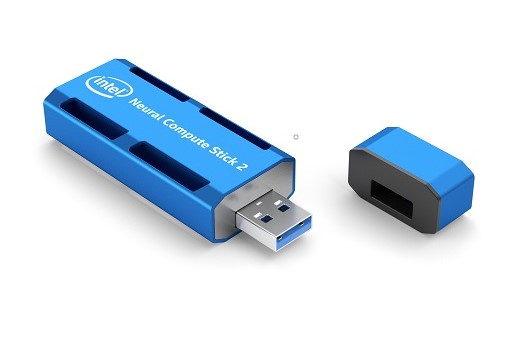" />

Intel Neural Compute Stick 2 is a product designed for accelerating vision algorithms and neural network models. It is delivered in form of a larger USB stick (hence the name) that can be easly used to work with PC or any other development board that has USB ports.

The core of the NCS consists of Intel Movidius Myriad X 4GB VPU (Vision Processing Unit) with 16 programmable cores and neural network engine which can work with frequency of up to 700MHz. NCS is compatible with most of the Linux distributions, Windows, MacOS and also Raspbian OS. To implement algorithms on NCS, Intel provides with OpenVINO environment that implements all necessary tools for model optimization, quantization, conversion and deployment on Intel accelerators. 

## Model deployment on NCS2

On this laboratories we will work with Intel NCS in version 2. Two important things have to be taken into consideration while using it:

1. As for now, NCS2 only supports algorithms running on 16-bit floating-point data, meaning it cannot be quantized more than to hafl-precision;
2. The distribution for NCS2 has ended in 2022 and the technical support by Intel ended this year in June, meaning that while working with NCS2 older versions of dedicated frameworks need to be used and some currently present on the Internet solutions may not be applicable.

Lastly, remember to source OpenVINO variables from OpenVINO Runtime library:

```
source openvino_2022.3.1/setupvars.sh
```

It is recomended to activate virtual environment first (`source .venv_ncs_cua/bin/activate`), than source OpenVINO variables (`source openvino_2022.3.1/setupvars.sh`) and after that run your notebook editor from sourced terminal (e.g. `code usb_accelerator_1_intel_ncs2_TODO.ipynb` or `jupyter usb_accelerator_1_intel_ncs2_TODO.ipynb`). These steps should be enough for you to deploy on NCS from jupyter notebook.

In case you had some problems with loading model to device or conecting to it, try to unplug and plug in again the device and restart your notebook editor. Another option is to reinstall OpenVINO Runtime:

```
rm -rf openvino_2022.3.1
curl -L https://storage.openvinotoolkit.org/repositories/openvino/packages/2022.3.1/linux/l_openvino_toolkit_ubuntu20_2022.3.1.9227.cf2c7da5689_x86_64.tgz --output openvino_2022.3.1.tgz
tar -xf openvino_2022.3.1.tgz
mv l_openvino_toolkit_ubuntu20_2022.3.1.9227.cf2c7da5689_x86_64 openvino_2022.3.1
cd openvino_2022.3.1
sudo -E ./install_dependencies/install_openvino_dependencies.sh
sudo ./install_dependencies/install_NCS_udev_rules.sh
cd ..
source openvino_2022.3.1/setupvars.sh
```

In [ ]:
from pathlib import Path
import time
import numpy as np
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from openvino.inference_engine import IECore, ExecutableNetwork

from usb_accelerator_utils import draw_classification_results, run_program

In [ ]:
# @TODO: Set the shape of input data i.e. size of input image (it will be later used for input scaling)
INPUT_IMAGE_WIDTH  = ...
INPUT_IMAGE_HEIGHT = ...
print(f'Input  shape: ({INPUT_IMAGE_HEIGHT}, {INPUT_IMAGE_WIDTH})')

# @TODO: Load label names for MobilNet classes, you can find example files here: https://coral.ai/models/all/. Does labels' number equals model output shape?
LABELS = ...
print('Labels shape:', np.shape(LABELS))

NCS2 uses OoenVINO's [Intermediate Representation](https://docs.openvino.ai/2023.2/openvino_ir.html) (IR) format to run model. Before we will run the conversion tool, let's organize our workspace.

In [ ]:
# @TODO: Provide path to TF model that was saved previously
model_tf_dir = Path(...)

if not model_tf_dir.exists():
  raise FileNotFoundError(f'Cannot find model directory on given path: {model_tf_dir}')

# @TODO: Provide path to directory where the converison results will be stored
model_ir_dir = Path(...)

model_ir_dir.mkdir(parents=True, exist_ok=True)

# @TODO: Name your model :)
model_name = ...

# Full path to IR reprezentation file
model_ir_path = Path(model_ir_dir, model_name+'.xml')

Now run the [Model Optimizer](https://www.intel.com/content/www/us/en/developer/articles/technical/model-optimizer-for-ncs2.html) (MO) tool to convert our model from TF format to IR format.

In [ ]:
# Input shape
input_shape = f'[1,{INPUT_IMAGE_HEIGHT},{INPUT_IMAGE_WIDTH},3]'

# MO command to run in console
mo_command  = f'''mo
                  --saved_model_dir "{model_tf_dir}"
                  --input_shape "{input_shape}"
                  --model_name "{model_name}"
                  --output_dir "{model_ir_dir}"
                  --compress_to_fp16
                  '''
mo_command = ' '.join(mo_command.split())
print(f'[ INFO ] Runing command:\n\' {mo_command} \'')
!{mo_command}
print(f'[ INFO ] Model saved to {model_ir_path}')

To read and load our model to NCS we will use [IECore](https://docs.openvino.ai/2022.3/api/ie_python_api/_autosummary/openvino.inference_engine.IECore.html) class provided by OpenVINO. As mentiones ealrier, due to the discontinuation of support for NCS2, OpenVINO 2022.3.1 is the last version that implements necessary functions for deploying ANN models on NCS thus there are many fuctionalities you will not find in the latest version (and may find it hard to find any documentation on deploying algorithms on NCS).

In [ ]:
device = 'MYRIAD' # Device type category, 'MYRIAD' is the name used to refer to NCS

# @TODO: initiate core class (IECore documentation site: https://docs.openvino.ai/2022.3/api/ie_python_api/_autosummary/openvino.inference_engine.IECore.html)
ie = ...
print(f'[ INFO ] Available devices: {ie.available_devices}')

# @TODO: Read model in IR format using IECore (IECore documentation site: https://docs.openvino.ai/2022.3/api/ie_python_api/_autosummary/openvino.inference_engine.IECore.html)
# @NOTE: You do not necessarily have to do it using IECore as there are others ways, find and implement them if you want to
net = ...

# Set input and output pointers to access input and output ports
input_blob  = next(iter(net.input_info))
output_blob = next(iter(net.outputs))

versions = ie.get_versions(device)
print(f'[ INFO ] For device {device}:')
print(f'MKLDNNPlugin version ... {versions[device].major}.{versions[device].minor}')
print(f'Build .................. {versions[device].build_number}')

The core of our application is different basing on hardware we use. Below function is used for executing model in IR format on Intel NCS2.

In [ ]:
def run_ncs_classification(exec_net: ExecutableNetwork, img: np.ndarray, max_classes: int=1, min_score: float=0.0) -> float:
  
  # @TODO: Prepare image so it fits into model input.
  #        Hint1: Use imported function `preprocess_input`
  # @NOTE: On MYRIAD the order in which program iterate over image is different: not by each channel of 
  #        every pixel (in common notation: IM_HEIGHT->IM_WIDTH->CHANNEL), but by each frame of every
  #        channel (CHANNEL->IM_HEIGHT->IM_WIDTH)
  #        Hint2: One of the possible solution is to use `transpose` function from Numpy library
  input_img = ...
  
  t0 = time.perf_counter()
  
  # @TODO: Perform one inference on prepared data
  #        Hint: https://docs.openvino.ai/2022.3/api/ie_python_api/_autosummary/openvino.inference_engine.ExecutableNetwork.html#openvino.inference_engine.ExecutableNetwork
  result = ...
  
  elapsed = time.perf_counter() - t0
  
  # @TODO: Extract classification scores, make it as a one-dimensional array
  scores = ...
  
  class_idxs = np.arange(start=0, stop=scores.shape[0], step=1, dtype=int)
  draw_classification_results(
    img=img,
    class_idxs=class_idxs,
    scores=scores,
    labels=LABELS,
    max_classes=max_classes,
    min_score=min_score)
  return elapsed

Last step is to load prepared model to NCS.

In [ ]:
t0 = time.perf_counter()

# @TODO: Load model to device (IECore documentation site: https://docs.openvino.ai/2022.3/api/ie_python_api/_autosummary/openvino.inference_engine.IECore.html)
exec_net = ...

t1 = time.perf_counter() - t0
print(f'[ INFO ] Load model to device - elapsed time: {t1:0.3f}s')

Finally run the application.

In [ ]:
run_program(
  exec_net=exec_net,
  c_func=run_ncs_classification,
  camera_idx=0,
  max_disp=3,
  min_score=0.1)